<a href="https://colab.research.google.com/github/AlexMa123/DCNN-SHHS/blob/main/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic sleep-stage classification of heart rate and actigraphy data using deep and transfer learning approaches

This notebook serves as a guide to train the neural network that has been presented in the research article titled **"Automatic sleep-stage classification of heart rate and actigraphy data using deep and transfer learning approaches"** using the SHHS dataset.

In [2]:
# !unzip DCNN-SHHS
!pip install git+https://github.com/AlexMa123/DCNN-SHHS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AlexMa123/DCNN-SHHS to /tmp/pip-req-build-t67wrwb5
  Running command git clone --filter=blob:none --quiet https://github.com/AlexMa123/DCNN-SHHS /tmp/pip-req-build-t67wrwb5
  Resolved https://github.com/AlexMa123/DCNN-SHHS to commit de1c02d802afdd2335ef12668e8deaebf9e5efa3
  Preparing metadata (setup.py) ... done
  Created wheel for DCNN-SHHS: filename=DCNN_SHHS-0.1.2-py3-none-any.whl size=4800 sha256=32ab87e8578219dd48e0d29a603a0976cd8a789dd30ee392196e0d2ef7deda76
  Stored in directory: /tmp/pip-ephem-wheel-cache-ovfvo_ic/wheels/e0/0c/d7/f26ec033d1df891f1e40d74f261152980303213e26e863ad33
Successfully built DCNN-SHHS


In [16]:
# import packages
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from DCNN_SHHS import DCNN_classifier, SleepDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import nn, optim

device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)

## SHHS Dataset

The [Sleep Heart Health Study (SHHS)](https://sleepdata.org/datasets/shhs) is a multi-center cohort study implemented by the National Heart Lung & Blood Institute to determine the cardiovascular and other consequences of sleep-disordered breathing. 

### Download Dataset

In [4]:
!wget "https://onedrive.live.com/download?cid=45D5A10F94E33861&resid=45D5A10F94E33861%21248707&authkey=AKRa5kb3XFj4G-o" -O shhs_dataset.h5

--2023-06-03 19:28:01--  https://onedrive.live.com/download?cid=45D5A10F94E33861&resid=45D5A10F94E33861%21248707&authkey=AKRa5kb3XFj4G-o
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://m10oca.db.files.1drv.com/y4mBCq7CxOJJvnlhg2mN8RF7wRZs5KrjeoBC95KIWzGNSz_upuGQ1aRWTPiTeFfScvLpdYEP0RghW_57_C4oaXlDWi09CO49alWOZTTNHm0NIssildwo8KRuBi0VtnTKAOXJd5rod84h0B0MigBuOoinltkp8UmXLfoVRrjrshLuj68sj-yJ-NnrGg2dVjJquPYHc-4anydLKfT7Gfw86FMzg/SHHS_dataset.h5?download&psid=1 [following]
--2023-06-03 19:28:01--  https://m10oca.db.files.1drv.com/y4mBCq7CxOJJvnlhg2mN8RF7wRZs5KrjeoBC95KIWzGNSz_upuGQ1aRWTPiTeFfScvLpdYEP0RghW_57_C4oaXlDWi09CO49alWOZTTNHm0NIssildwo8KRuBi0VtnTKAOXJd5rod84h0B0MigBuOoinltkp8UmXLfoVRrjrshLuj68sj-yJ-NnrGg2dVjJquPYHc-4anydLKfT7Gfw86FMzg/SHHS_dataset.h5?download&psid=1
Resolving m10oca.db.files.1drv.com (m10oca.db.files.

## Data structure

The dataset created by us only save the 4 Hz RR interval and sleep stages.

![RR interval](https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/Heart_rate_variability_%28HRV%29.svg/1280px-Heart_rate_variability_%28HRV%29.svg.png)

The sleep stages is saved as interger numbers:

|number|stage|
|------|-----|
|  0   | Wake|
|  1   | N1  |
|  2   | N2  |
|  3   | N3  |
|  5   | REM |
| other| artifact|



In [5]:
shhs_dataset = h5py.File("./shhs_dataset.h5", 'r')

# where the rris are saved
shhs_dataset['rri']
# where the sleep stages are saved
shhs_dataset['slp']

# The patients' id
patients = list(shhs_dataset['rri'].keys())
print(patients[:10])

['200001_1', '200002_1', '200003_1', '200004_1', '200005_1', '200006_1', '200007_1', '200008_1', '200009_1', '200010_1']


To load the patient 200080's rri and sleep stage, one should use 

In [6]:
freq_rri = shhs_dataset['rri'].attrs['freq']
print(f"The frequency of RR interval is {freq_rri} Hz")

The frequency of RR interval is 4 Hz


In [7]:
# 200080_1 means the first night recording from patient 200001
rri_tmp = shhs_dataset['rri']['200080_1'][:] # rri_tmp is an array of data
slp_tmp = shhs_dataset['slp']['200080_1'][:]

Text(0, 0.5, 'RRI/s')

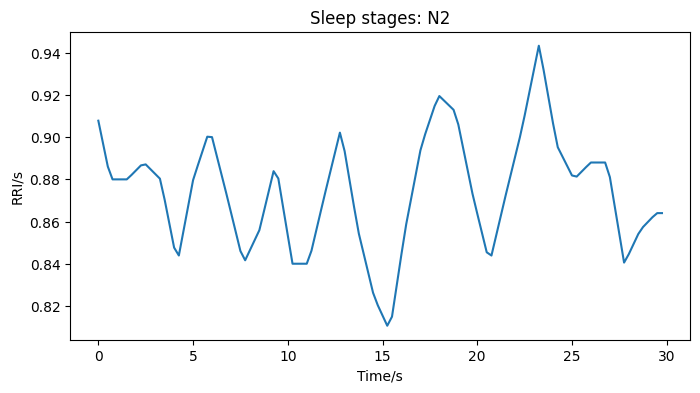

In [8]:
num2stage = {
    0: 'wake',
    1: 'N1',
    2: 'N2',
    3: 'N3',
    5: 'REM'
}

# plot the ith epoch
i = 13
plt.figure(figsize=(8, 4))
plt.plot(np.arange(0, 30, 1 / 4), rri_tmp[i * 30 * 4: (i + 1) * 30 * 4])
plt.title(f"Sleep stages: {num2stage[slp_tmp[i]]}")
plt.xlabel("Time/s")
plt.ylabel("RRI/s")

## Train test data split

As we have access to a list of patient IDs, we can utilize the train_test_split function from the sklearn library to partition the dataset into training, validation, and test sets.

In [9]:
train_pid, test_pid = train_test_split(patients, test_size=0.3, shuffle=True)
validation_pid, test_pid = train_test_split(test_pid, test_size=0.5, shuffle=True)

print(len(train_pid), len(test_pid), len(validation_pid))

5803 1244 1244


In [11]:
batchsize = 16

train_dataset = SleepDataset(
    shhs_dataset,  # The h5 dataset load by h5py
    features=['rri'], target='slp',
    remove_mean={'rri':False}, # whether to remove mean value from the signal or not
    batchsize=batchsize,
    pid=train_pid,
    shuffle=True
)

validation_dataset = SleepDataset(
    shhs_dataset, 
    features=['rri'], target='slp',
    remove_mean={'rri':False},
    batchsize=batchsize,
    pid=validation_pid,
    shuffle=True
)

test_dataset = SleepDataset(
    shhs_dataset, 
    features=['rri'], target='slp',
    remove_mean={'rri':False},
    batchsize=batchsize,
    pid=test_pid,
    shuffle=True
)

In [12]:
for X, Y, _, _ in tqdm(train_dataset, total=int(len(train_pid) / batchsize)):
    rri = X['rri']
    slp = Y

363it [00:31, 11.66it/s]                         


## Define the neural network model

In [13]:
net = DCNN_classifier() # using the default model, which is the same as what wrote in the paper
net = net.to(device)

In [15]:
# The input of the network could be a rri or rri with ACT
fake_rri = torch.rand(1, 1200, 512, device=device) 
# (batch_size, number of windows, number of samples in each window (128s))
fake_mad = torch.rand(1, 1200, 128, device=device)

print(net(fake_rri).shape)
# or
print(net(fake_rri, fake_mad).shape)

torch.Size([1200, 4])
torch.Size([1200, 4])


## Network Training

### Learning rate
The network is trained by Adam optimizer with a warm-up learning rate, and the learning rate increases from $2.5\times 10^{-5}$ to $1\times 10^{-4}$ during the first 10 epochs and then decreases to $5\times 10^{-5}$ for the following 30 epochs.

In [20]:
import math
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

Text(0.5, 0, 'epoch')

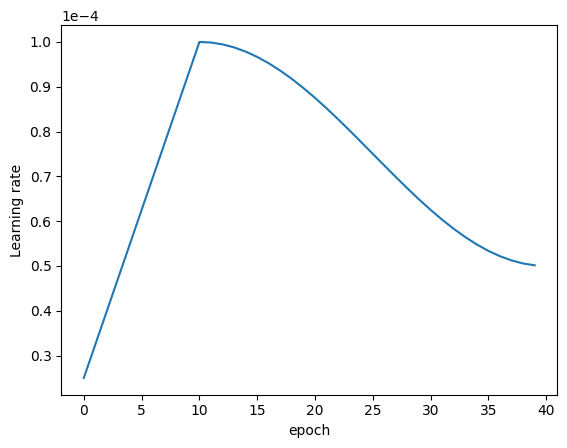

In [21]:
lr_scheduler = CosineScheduler(40, 
                               1 * 1e-4, 5 * 1e-5, 
                               warmup_steps=10, warmup_begin_lr=2.5 * 1e-5)
epochs = np.arange(40)
lrs = np.array([lr_scheduler(e) for e in epochs])
plt.plot(epochs, lrs)
plt.ylabel("Learning rate")
plt.gca().ticklabel_format(style='sci', scilimits=(-1, 2), axis='y')
plt.xlabel("epoch")

### Optimizer and Loss function

In [17]:
opt = optim.Adam(net.parameters(), lr=0.000005)
loss = nn.CrossEntropyLoss()
loss_train = []
loss_validation = []
acc_train = []
acc_validation = []

import os
if not os.path.isdir("./training_result"):
  os.mkdir("training_result")

In [22]:
for epoch in range(lr_scheduler.max_update):
  train_dataset = SleepDataset(
    shhs_dataset,  # The h5 dataset load by h5py
    features=['rri'], target='slp',
    remove_mean={'rri':False}, # whether to remove mean value from the signal or not
    batchsize=batchsize,
    pid=train_pid,
    shuffle=True
  )
  net.train()
  print(f"Training epoch {epoch}")
  for X, Y, _, _ in tqdm(train_dataset, total=int(len(train_pid) / batchsize)):
    rri = X['rri'].to(device)
    slp = Y.to(device)
    # Only keeps Wake, Light Sleep, Deep Sleep and REM sleep
    slp[slp>=1] = slp[]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
